<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC1</p>
<p style="margin: 0; text-align:right;">2022-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 1: Redes neuronales artificiales y convolucionales con Keras

A lo largo de esta práctica vamos a implementar varios modelos de redes neuronales para clasificar las imágenes de una base de datos de imágenes satelitales. En concreto:
- Se implementará una red completamente conectada para establecer un modelo de referencia o <i>baseline</i>
- Se implementará una red convolucional
- Se implementará un autoencoder
- Se implementará una red convolucional profunda a partir de un modelo conocido (VGG16) pre-entrenado en Imagenet utilizando <i>transfer-learning</i>

<u>Consideraciones generales</u>: 

- La solución planteada no puede utilizar métodos, funciones o parámetros declarados **_deprecated_** en futuras versiones, a excepción de la carga de datos cómo se indica posteriormente.
- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

## 0. Contexto y carga de librerías
Las imágenes tomadas por satélite son clave en la supervisión del uso y la cobertura del suelo, cuestiones relevantes para la gestión ambiental, la planificación urbana, la sostenibilidad y para combatir el cambio climático.

En esta práctica, trabajaremos con la base de datos [UC Merced Land Use Data](http://weegee.vision.ucmerced.edu/datasets/landuse.html), que consiste en imágenes satelitales de 256x256 píxeles de 21 escenas diferentes: las clases son diversas, conteniendo escenas e imágenes de aviones o ríos, entre otras categorías.

Concretamente trabajaremos con una versión aumentada de dicha base de datos que está disponible en un [repositorio de Kaggle](https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification). En esta versión se han llevado a cabo varios procesos de aumentación de datos de tal forma que el número de imágenes por clase pasa de 100 a 500.

**Nota: Se recomienda realizar la práctica en el entorno que ofrece la plataforma Kaggle, ya que ofrece un entorno gratuito con 30 horas semanales de uso de GPU.**

A lo largo de toda la práctica, para la creación de las distintas redes, iremos alternando el uso del modelo [Sequential](https://keras.io/guides/sequential_model/) y el modelo [Functional](https://keras.io/guides/functional_api/) de Keras a través de las clases [Sequential](https://keras.io/api/models/sequential/) y [Model](https://keras.io/api/models/model/) respectivamente.

Empezamos cargando las librerías mas relevantes:

In [1]:
# Importamos tensorflow
import tensorflow as tf
print("TF version   : ", tf.__version__)

# Necesitaremos GPU
print("GPU available: ", tf.config.list_physical_devices('GPU'))

# keras version is 2.11.0
import keras
print("Keras version   : ", keras.__version__)

TF version   :  2.11.0
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Keras version   :  2.11.0


In [21]:
# Importamos los elementos de keras que utilizaremos con mayor frecuencia
from keras.utils import image_dataset_from_directory
from keras.layers import (
    GlobalAveragePooling2D, Flatten,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, 
    MaxPooling2D, UpSampling2D, Rescaling, Resizing, Input)
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import Sequential, Model
from PIL import Image

In [3]:
# Importamos el resto de librerías que necesitaremos para la PEC
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

## 1. Descarga, análisis y pre-procesado de los datos (1,5 puntos)

En este apartado exploraremos la base de datos y prepararemos la carga de las imágenes para los modelos de los siguientes apartados.

Para la descarga de la base de datos tenemos 2 opciones dependiendo de si decidimos trabajar en local o desde el entorno de Kaggle:
- Si trabajamos en local debemos descargar la base de datos desde el siguiente [enlace](https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification/download?datasetVersionNumber=3) (es un archivo .zip que ocupa 2 GB) y descomprimirlo.
- Si trabajamos desde Kaggle. Debemos subir el Notebook del enunciado a la plataforma (para ello podéis seguir los 6 primeros pasos del siguiente [artículo](https://rajputankit22.medium.com/how-to-upload-my-own-notebook-to-kaggle-2b0dedbb5a6b)) y después, una vez subido el notebook, clickar el botón '+ Add Data' y en la caja de búsqueda introducir la dirección 'https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification'. Una vez encontrado el dataset darle al botón '+' (Add Dataset), y desde ese momento ya tendréis accesible la base de datos en la ruta <code>../input/</code>.

Una vez tenemos la base de datos accesible vamos a inspeccionarla.

Las imágenes se encuentran agrupadas de 2 formas diferentes:
- En la carpeta <code>/landuse-scene-classification/images/</code> se encuentra el total de las imágenes separadas por clases (cada clase en una carpeta distinta). Pero no se ha realizado una separación en conjunto de entrenamiento y test (o entrenamiento, validación y test).
- En la carpeta <code>/landuse-scene-classification/images_train_test_val/</code> se encuentran 3 carpetas (<code>test</code>, <code>train</code> y <code>validation</code>) en las que el total de imágenes se ha separado de forma aleatoria. En cada una de las 3 carpetas, tenemos imágenes de las 21 clases agrupadas en sus correspondientes carpetas. En la carpeta raíz <code>/landuse-scene-classification/</code> tenemos 3 archivos .csv con la distribución de cada carpeta.

En esta práctica utilizaremos el dataset ya particionado, es decir, trabajaremos con las imágenes que se encuentran en la ruta <code>/landuse-scene-classification/images_train_test_val/</code>.

### 1.1. Análisis de los archivos .csv

A partir de los archivos .csv podemos ver cómo se han distribuído los datos. Por ejemplo:

In [4]:
train = pd.read_csv('../input/landuse-scene-classification/train.csv')
test = pd.read_csv('../input/landuse-scene-classification/test.csv')
validation = pd.read_csv('../input/landuse-scene-classification/validation.csv')
train.head(5)

Unnamed: 0                              Filename  Label     ClassName
0        5818              runway/runway_000259.png     16        runway
1        1327  intersection/intersection_000348.png     10  intersection
2        2529  agricultural/agricultural_000025.png      0  agricultural
3        3865        chaparral/chaparral_000195.png      5     chaparral
4        2024          airplane/airplane_000260.png      1      airplane

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [0,5 pts.]:</strong> A partir de los 3 archivos .csv se pide:
    <ul>
        <li>Extraer los nombres de las 21 clases (esto sólo hace falta hacerlo en uno de los 3 archivos)</li>
        <li>¿Cuántas instancias tenemos en total para cada conjunto de datos?</li>
        <li>Comprobar que las clases están balanceadas en los 3 conjuntos de datos (contando para cada conjunto, cuantas instancias/ejemplos tenemos para cada clase)</li>
    </ul>        
</div>

In [5]:
# Extraer nombres de las clases
classes = list(train['ClassName'].unique())
print(f"Las 21 clases son: {' '.join(classes).replace(' ', ', ')}")

Las 21 clases son: runway, intersection, agricultural, chaparral, airplane, storagetanks, tenniscourt, overpass, harbor, buildings, mediumresidential, baseballdiamond, golfcourse, freeway, sparseresidential, river, mobilehomepark, forest, beach, parkinglot, denseresidential


In [6]:
# Número de instancias por conjunto
print(f"Instancias train-set: {train.shape[0]}")
print(f"Instancias validation-set: {validation.shape[0]}")
print(f"Instancias test-set: {test.shape[0]}")

Instancias train-set: 7350
Instancias validation-set: 2100
Instancias test-set: 1050


In [120]:
# Número de instancias por clase
pd.DataFrame({'train':train['ClassName'].value_counts(), 'validation':validation['ClassName'].value_counts(),'test':test['ClassName'].value_counts()})

train  validation  test
agricultural         350         100    50
airplane             350         100    50
baseballdiamond      350         100    50
beach                350         100    50
buildings            350         100    50
chaparral            350         100    50
denseresidential     350         100    50
forest               350         100    50
freeway              350         100    50
golfcourse           350         100    50
harbor               350         100    50
intersection         350         100    50
mediumresidential    350         100    50
mobilehomepark       350         100    50
overpass             350         100    50
parkinglot           350         100    50
river                350         100    50
runway               350         100    50
sparseresidential    350         100    50
storagetanks         350         100    50
tenniscourt          350         100    50

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
El dataset consiste en 21 clases de imágenes satelitales etiquetadas.<br><br>
El tamaño total son 10.500 imágenes con un train-validation-test split de 70%, 20% y 10% respectivamente.<br><br>
Dentro de cada conjunto, las clases estan balanceadas equitativamente.
<br><br> 
</div>

### 1.2. Análisis de las carpetas de imágenes.

Aunque se supone que cada archivo .csv refleja a la perfección el contenido de cada conjunto de datos, no está demás cerciorarse que el contenido del mismo se corresponde con lo anotado en cada archivo. Para ello se pide:

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio[0,5 pts]:</strong> Proporciona, a partir de las carpetas de imágenes, el número de imágenes que tenemos en cada categoría para cada conjunto de datos, comprobando que coincide con lo estipulado en el archivo .csv, y visualiza a modo de ejemplo una imagen por cada categoría. ¿Qué rango dinámico (valores mínimo y máximo) tienen las imágenes?
</div>

train.csv tiene 350 instancias por clase: [350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350]



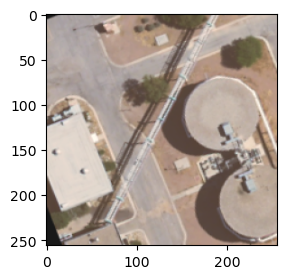

In [6]:
# Para el conjunto de datos de entrenamiento
train_ins = [len(os.listdir('../input/landuse-scene-classification/images_train_test_val/train/'+c))for c in classes]
print(f"train.csv tiene 350 instancias por clase: {train_ins}\n")

# Plot de imagen
random_class = '../input/landuse-scene-classification/images_train_test_val/train/' + classes[np.random.randint(0, len(classes))]
random_image = os.listdir(random_class)[np.random.randint(0, train_ins[0])]
plt.figure(figsize=(3,3))
plt.imshow(plt.imread(random_class + '/' + random_image))
plt.show()

validation.csv tiene 100 instancias por clase: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]



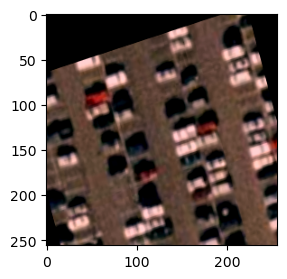

In [9]:
# Para el conjunto de datos de validación
validation_ins = [len(os.listdir('../input/landuse-scene-classification/images_train_test_val/validation/'+c))for c in classes]
print(f"validation.csv tiene 100 instancias por clase: {validation_ins}\n")

# Plot de imagen
random_class = '../input/landuse-scene-classification/images_train_test_val/validation/' + classes[np.random.randint(0, len(classes))]
random_image = os.listdir(random_class)[np.random.randint(0, validation_ins[0])]
plt.figure(figsize=(3,3))
plt.imshow(plt.imread(random_class + '/' + random_image))
plt.show()

test.csv tiene 50 instancias por clase: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]



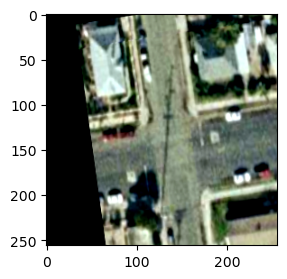

In [10]:
# Para el conjunto de datos de test
test_ins = [len(os.listdir('../input/landuse-scene-classification/images_train_test_val/test/'+c))for c in classes]
print(f"test.csv tiene 50 instancias por clase: {test_ins}\n")

# Plot de imagen
random_class = '../input/landuse-scene-classification/images_train_test_val/test/' + classes[np.random.randint(0, len(classes))]
random_image = os.listdir(random_class)[np.random.randint(0, test_ins[0])]
plt.figure(figsize=(3,3))
plt.imshow(plt.imread(random_class + '/' + random_image))
plt.show()

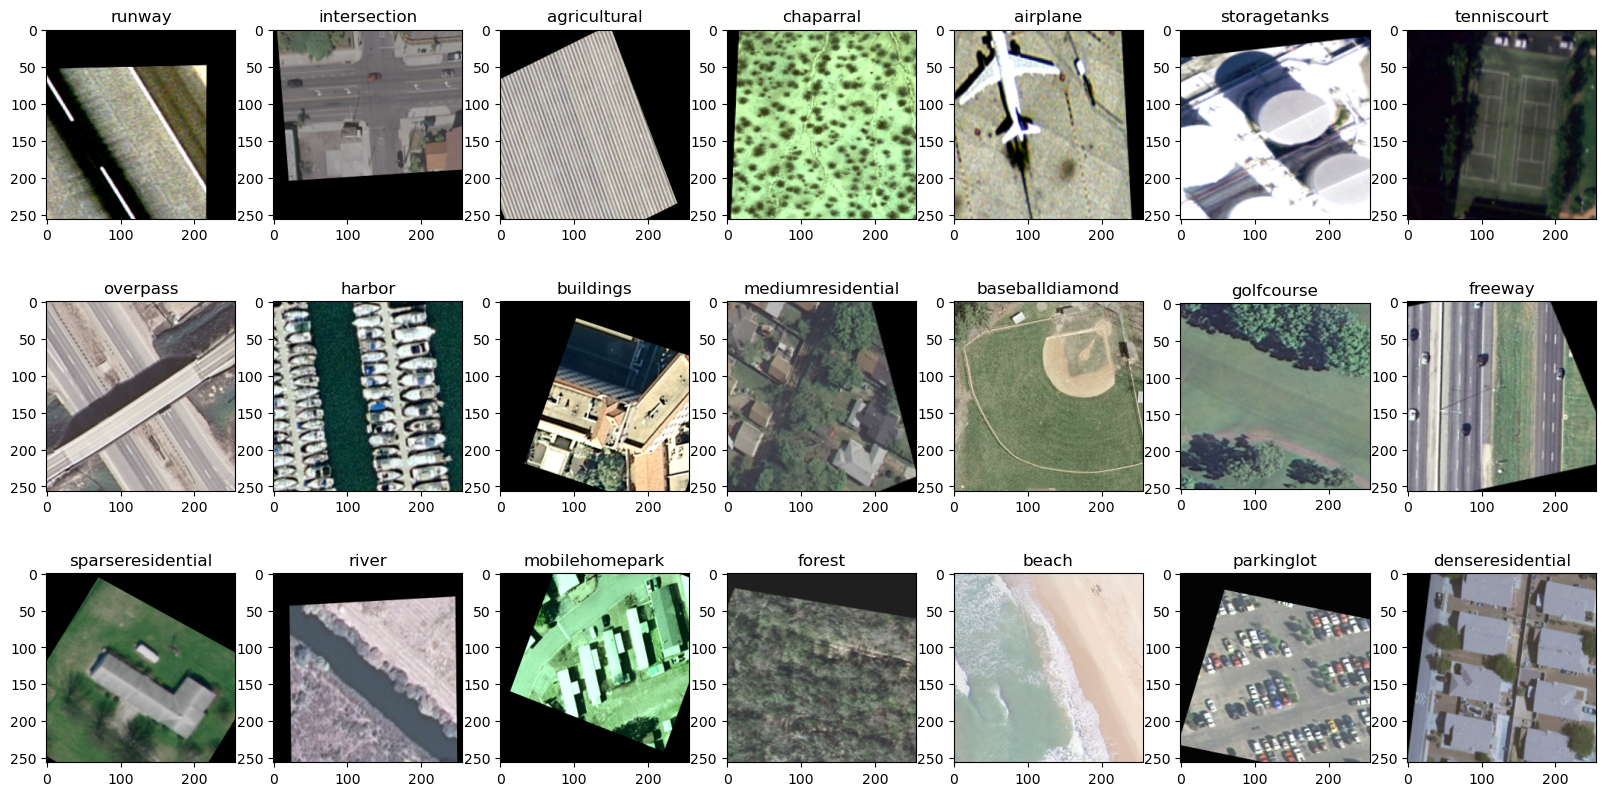

In [18]:
# Visualizacion todas las clases
plt.figure(figsize=(20,10))
for i in range(len(classes)):
    plt.subplot(3,7,i+1)
    class_ = '../input/landuse-scene-classification/images_train_test_val/train/' + classes[i]
    random_image = os.listdir(class_)[np.random.randint(0, train_ins[0])]
    plt.title(classes[i])
    plt.imshow(plt.imread(class_ + '/' + random_image))
plt.show()

¿Qué rango dinámico (valores mínimo y máximo) tienen las imágenes?

Los rangos dinámicos son entre 0 y 255 al tratarse de imágenes RGB. Si se lee la imagen con plt.imread(), se normaliza automáticamente entre 0 y 1.

In [28]:
print("Los rangos dinámicos son entre: 0 y",np.max(np.array(Image.open(random_class + '/' + random_image))))

Los rangos dinámicos son entre: 0 y 255


### 1.3. Creación de los conjuntos de datos en formato Keras/Tensorflow
​
Con el objetivo de crear una base de datos en el formato Keras/Tensorflow a partir de las imágenes proporcionadas utilizaremos la función <code>**tf.keras.utils.image_dataset_from_directory()**</code> ya que nos permite crear bases de datos a partir de imágenes guardadas en carpetas.

La documentación de esta función se encuentra tanto en la web de [Keras](https://keras.io/api/data_loading/image/) como en la de [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) .

Además, aprovecharemos para redimensionar las imágenes y pasarlas a tamaño 224x224, que es el tamaño con el que se ha entrenado la red VGG16 que utilizaremos en un apartado posterior.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio[0,5 pts]:</strong> Utiliza la función  <code>image_dataset_from_directory()</code> para generar 3 conjuntos de datos (<code>train_data</code>, <code>val_data</code> y <code>test_data</code>) a partir de las carpetas analizadas. Las imágenes deben ser redimensionadas a tamaño 224x224 píxels RGB (224,224,3) y agrupadas en lotes de tamaño 32 (batch=32) manteniendo su rango dinámico.
</div>

In [6]:
directory = '../input/landuse-scene-classification/images_train_test_val/'
# Cargamos el dataset utilizando la función de keras
train_data = tf.keras.utils.image_dataset_from_directory(directory+'train', image_size=(256, 256), batch_size=32)
val_data = tf.keras.utils.image_dataset_from_directory(directory+'validation', image_size=(256, 256), batch_size=32)
test_data = tf.keras.utils.image_dataset_from_directory(directory+'test', image_size=(256, 256), batch_size=32)

Found 7350 files belonging to 21 classes.
Found 2100 files belonging to 21 classes.
Found 1050 files belonging to 21 classes.


In [7]:
# Cambiamos el tamaño de 256x256x3 a 224x224x3
def resize_images(image, label):
    resized_image = tf.image.resize(image, (224, 224))
    return resized_image, label

In [8]:
# Mostramos el tamaño de un batch antes de la transformacion
print([im.shape for im,label in train_data.take(1)][0])

# LLamamos a la función resize_images para cada conjunto de datos
train_data = train_data.map(resize_images)
val_data = val_data.map(resize_images)
test_data = test_data.map(resize_images)

# Mostramos el tamaño de un batch después de la transformacion
print([im.shape for im,label in train_data.take(1)][0])


(32, 256, 256, 3)
(32, 224, 224, 3)


## 2. Modelo ANN (1,5 puntos)

En este apartado, vamos a entrenar y evaluar un modelo muy sencillo completamente conectado para establecer un resultado de referencia.

Dado que en una red neuronal artificial las entradas son unidimensionales, lo primero que tenemos que hacer es redimensionar los datos de entrada (las imágenes) para convertirlos en arrays de una dimensión.

Como trabajar con imágenes de tamaño 224x224 en una red completamente conectada implicaría entrenar un número de parámetros excesivamente elevado definiremos un modelo en el que se realizará previamente un redimensionado de las imágenes de entrada a un tamaño de 32x32 y un achatamiento (*flattening*) de los píxeles para así generar un vector unidimensional de tamaño 3072 (32x32x3). 

Posteriormente entrenaremos un clasificador (una red completamente conectada) para llevar a cabo la clasificación de nuestros datos.

En este apartado utilizaremos las capas [Resizing](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/resizing/), [Rescaling](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/), [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/), [Dense](https://keras.io/api/layers/core_layers/dense/) y [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) de keras.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio:</strong> Implementa un modelo <strong>secuencial</strong> de Keras (a partir de la clase <code>Sequential()</code>) con las siguientes especificaciones:
    <ul>
        <li>Una capa que reduzca las dimensiones de entrada de (224,224) a (32,32)</li>
        <li>Una capa de reescalado para conseguir que los valores de la imagen estén entre 0 y 1</li>
        <li>Una capa Flatten para convertir la imagen en un vector de 3072 posiciones</li>
        <li>Una capa completamente conectada de 1024 neuronas y activación ReLU</li>
        <li>Una capa de Dropout (con probabilidad 0.5)</li>
        <li>Una capa de salida completamente conectada correspondiente a la clasificación final cuyo número de neuronas debe ser igual al múmero de clases de la base de datos y con la función de activación adecuada para llevar a cabo esta tarea de clasificación.</li>
    </ul>
        
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.0001.</li>
         <li>Entrenar durante 100 épocas utilizando  <i>EarlyStopping</i> con una persistencia de 10 épocas, monitorizando la función de pérdida en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li>Monitorizar la métrica  <i>accuracy</i> durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas de accuracy y loss. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación. NOTA: Se recomienda hacer una función que imprima ambas gráficas para poder reutilizarla en próximos apartados.</li>
         <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la exactitud final sobre los datos de test.</li>
    </ul>
    Preguntas a responder: ¿Cúal es el número de parámetros a entrenar? ¿y el tiempo de entrenamiento? ¿Qué precisión se obtiene con este modelo? Comenta los resultados.<br/>    
    <strong> NOTA: se recomienda, al final de la creación de cada modelo, utilizar la función <code>summary()</code> para comprobar la estructura de la red creada, así como el numero de parámetros que se deben entrenar. Se recomienda hacerlo en todos los ejercicios.</strong>
</div>

In [28]:
# Definición de la red
model_ann = Sequential([
    
    # Capa de reducción de dimensiones
    Resizing(height=32, width=32, input_shape=(224, 224, 3)),
    
    # Capa de reescalado con valores entre 0 y 1
    Rescaling(scale=1./255),
    
    # Capa Flatten para convertir la imagen en un vector
    Flatten(),
    
    # Capa completamente conectada de 1024 neuronas y activación ReLU
    Dense(units=1024, activation='relu'),
    
    # Capa Dropout (con probabilidad 0.5)
    Dropout(rate=0.5),
    
    # Capa de salida completamente conectada y activación Softmax
    Dense(units=len(classes), activation='softmax')
])

In [29]:
# Compilación de la red
model_ann.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
# Entrenamiento de la red

# EarlyStopping con una persistencia de 10 épocas (no hay mejora en 10 épocas)
# monitorizando la función de pérdida en el conjunto de validación (val_loss)
early_stop_ann = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Guardando los pesos que mejor resultado hayan obtenido.
model_checkpoint_ann = ModelCheckpoint(filepath='best_model_ann.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Ejecución modelo
history_ann = model_ann.fit(train_data, epochs=100, validation_data=val_data, callbacks=[early_stop_ann, model_checkpoint_ann])

Epoch 1/100
229/230 [============================>.] - ETA: 0s - loss: 3.1100 - accuracy: 0.0662
Epoch 1: val_loss improved from inf to 2.99606, saving model to best_model_ann.h5
230/230 [==============================] - 29s 122ms/step - loss: 3.1097 - accuracy: 0.0664 - val_loss: 2.9961 - val_accuracy: 0.0824
Epoch 2/100
228/230 [============================>.] - ETA: 0s - loss: 2.9984 - accuracy: 0.0890
Epoch 2: val_loss improved from 2.99606 to 2.97086, saving model to best_model_ann.h5
230/230 [==============================] - 31s 134ms/step - loss: 2.9985 - accuracy: 0.0894 - val_loss: 2.9709 - val_accuracy: 0.0881
Epoch 3/100
228/230 [============================>.] - ETA: 0s - loss: 2.9569 - accuracy: 0.1053
Epoch 3: val_loss improved from 2.97086 to 2.93994, saving model to best_model_ann.h5
230/230 [==============================] - 28s 118ms/step - loss: 2.9569 - accuracy: 0.1049 - val_loss: 2.9399 - val_accuracy: 0.1095
Epoch 4/100
228/230 [============================>.] 

In [10]:
# Plot del training loss i l'accuracy
# Mostrar las gráficas de accuracy y loss. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación.
def plot_history(history, accuracy=True):
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    if accuracy:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        epochs = range(1, len(acc) + 1)
        plt.figure(figsize=(15,5))
        # Gráfico de accuracy
        plt.subplot(121)
        plt.plot(epochs, acc, 'bo', label='Training acc')
        plt.plot(epochs, val_acc, 'b', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.subplot(122)
    else:
        epochs = range(1,len(loss) + 1)    
        plt.figure(figsize=(8,5))
        
    # Gráfico de loss
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

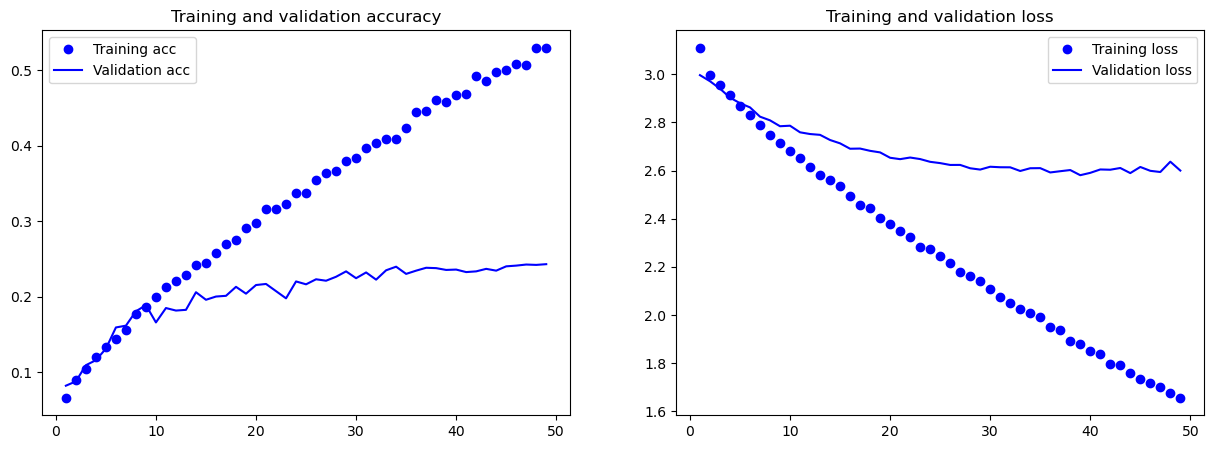

In [40]:
# Graficar las curvas de entrenamiento y validación
plot_history(history_ann)

In [41]:
# Evaluación del modelo sobre el subconjunto test
test_loss_ann, test_acc_ann = model_ann.evaluate(test_data, verbose=0)
num_params_ann = model_ann.count_params()
print("Pérdida final en el subconjunto test: {:.4f}".format(test_loss_ann))
print("Exactitud final en el subconjunto test: {:.4f}".format(test_acc_ann))
print(f"Número de parámetros: {num_params_ann}")

Pérdida final en el subconjunto test: 2.6134
Exactitud final en el subconjunto test: 0.2390
Número de parámetros: 3168277


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
¿Cúal es el número de parámetros a entrenar?
<br>
Hay 3.168.277 parámetros
<br><br>
¿y el tiempo de entrenamiento?
<br>
Aproximadamente unos 25 minutos utilizando una GPU
<br><br>
¿Qué precisión se obtiene con este modelo?
<br>
La pérdida final es de 2.6150 y la exactitud final de 0.2333
<br><br>
Los resultados obtenidos indican que el modelo no tiene un buen rendimiento en la tarea de clasificación. La pérdida y la exactitud final en el subconjunto de test indican que el modelo no está aprendiendo de manera efectiva las características relevantes de los datos.
<br><br>
El hecho de que el EarlyStopping haya terminado la ejecución en la época 49 (recuperando el modelo de la época 39) sugiere que el modelo esta sufriendo de overfitting, donde el modelo se ajusta demasiado a los datos de entrenamiento y no generaliza bien los datos nuevos.
<br><br>
En cuanto a las gráficas, para el entrenamiento se observa una curva ascendente (exactitud) y descendente (pérdida). Sin embargo, para la validación la gráfica sugiere también un sobreajuste a los datos de entrenamiento, ya que no es creciente/decreciente de manera constante.
<br><br>
</div>

## 3. Red convolucional pequeña (2 puntos)

Dadas las bajas prestaciones del modelo anterior vamos a probar otro tipo de redes con el objetivo de obtener unos mejores resultados en la tarea de clasificación que debemos llevar a cabo.

Las redes convolucionales (CNN) son especialmente adecuadas para modelar datos donde hay patrones en 2 dimensiones, como es el caso de las imágenes.

En la tarea de clasificación, la estructura de una CNN se divide en dos grandes bloques:

* **Bloque extractor de características**: En este bloque se generan diferentes niveles de abstracción de la imagen de entrada mediante capas convolucionales. Cuanto más profundas son estas capas, más preparadas están para la tarea de clasificación.
* **Clasificador**: Este bloque está formado por capas totalmente conectadas, la salida de deste bloque será la probabilidad asociada a cada clase.

En el apartado anterior, el bloque "extractor de características" era extremadamente simple, por no decir inexistente. En este apartado, vamos a hacer uso de capas convolucionales para poder aprender mejores abstracciones de las imágenes de entrada con el fin de mejorar su clasificación.

En este apartado utilizaremos las capas [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/),  [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/), [GlobalAveragePooling2D](https://keras.io/api/layers/pooling_layers/global_average_pooling2d/), [Dense](https://keras.io/api/layers/core_layers/dense/) y [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) de keras.

**Nota: Se recomienda, a partir de este punto realizar el entrenamiento en una máquina con GPU (puede activarse en plataformas como Google Colab o Kaggle) con el fin de reducir los tiempos de entrenamiento.**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio [2 puntos]:</strong> A partir del modelo <strong>funcional</strong> de keras (y la clase <code>Model()</code>), implementa una red con las siguientes características:
    <ul>
        <li>Un bloque extractor de características que conste de:
            <ul>
                <li>Una capa de entrada de dimensiones adecuadas a los datos.</li>
                <li>Una capa de rescalado para conseguir que los valores de la imagen estén entre 0 y 1.</li>
                <li>3 capas convolucionales con tamaño de kernel (5x5) para la primera y (3x3) para las 2 siguientes. Se utilizará padding '<i>same</i>' y activación ReLU. El número de filtros para cada capa convolucional será 16, 32 y 64 respectivamente.</li>
                <li>A cada capa convolucional le sigue una capa de <i>Max Pooling</i></li>
                <li>Una capa de <i>average pooling</i> (GlobalAveragePooling2D) para reducir las dimensiones a un vector de 1024 dimensiones.</li>
            </ul></li>
        <li>El clasificador final sigue la estructura del modelo del apartado anterior:
            <ul>
                <li>Una capa completamente conectada de 1024 neuronas y activación ReLU</li>
                <li>Una capa de Dropout (con probabilidad 0.5)</li>
                <li>Una capa de salida completamente conectada correspondiente a la clasificación final cuyo número de neuronas debe ser igual al múmero de clases de la base de datos y con la función de activación adecuada para llevar a cabo esta tarea de clasificación.</li>
            </ul></li>
    </ul>
    
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.001.</li>
          <li>Entrenar durante 100 épocas utilizando  <i>EarlyStopping</i> con una persistencia de 10 épocas, monitorizando la función de pérdida en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li>Monitorizar la métrica  <i>accuracy</i> durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas de <i>accuracy</i> y <i>loss</i>. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación.</li>
         <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la exactitud final sobre los datos de test.</li>
    </ul>
    Preguntas a responder: ¿Cúal es el número de parámetros a entrenar? ¿y el tiempo de entrenamiento? ¿Qué precisión se obtiene con este modelo? Comenta los resultados.
</div>

In [9]:
# Definición de la red
### Bloque extractor de características

# Capa de entrada
inputs = Input(shape=(224, 224, 3))

# Capa de rescalado para conseguir que los valores de la imagen estén entre 0 y 1.
rescale = Rescaling(scale=1./255)(inputs)

# 3 capas convolucionales con kernel 5x5,3x3,3x3. Se utilizará padding 'same' y activación ReLU.
# El número de filtros para cada capa convolucional será 16, 32 y 64 respectivamente.
# A cada capa convolucional le sigue una capa de Max Pooling
conv_layer1 = Conv2D(16, (5, 5), padding='same', activation='relu')(rescale)
pool_layer1 = MaxPooling2D((2, 2))(conv_layer1)
conv_layer2 = Conv2D(32, (3, 3), padding='same', activation='relu')(pool_layer1)
pool_layer2 = MaxPooling2D((2, 2))(conv_layer2)
conv_layer3 = Conv2D(64, (3, 3), padding='same', activation='relu')(pool_layer2)
pool_layer3 = MaxPooling2D((2, 2))(conv_layer3)

# Capa GlobalAveragePooling2D para reducir las dimensiones a un vector de 1024 dimensiones
global_pool = GlobalAveragePooling2D()(pool_layer3)

### El clasificador final
# Una capa completamente conectada de 1024 neuronas y activación ReLU
dense_layer = Dense(1024, activation='relu')(global_pool)

# Una capa de Dropout (con probabilidad 0.5)
dropout_layer = Dropout(0.5)(dense_layer)

# Una capa de salida completamente conectada
outputs = Dense(len(classes), activation='softmax')(dropout_layer)

# Crear el modelo
model_cnn = Model(inputs=inputs, outputs=outputs)

In [10]:
# Compilación de la red
model_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [38]:
# Entrenamiento

# EarlyStopping con una persistencia de 10 épocas (no hay mejora en 10 épocas)
# monitorizando la función de pérdida en el conjunto de validación (val_loss)
early_stop_cnn = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Guardando los pesos que mejor resultado hayan obtenido.
model_checkpoint_cnn = ModelCheckpoint(filepath='best_model_cnn.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Entrenar el modelo
history_cnn = model_cnn.fit(train_data, epochs=100, validation_data=val_data, callbacks=[early_stop_cnn, model_checkpoint_cnn])

Epoch 1/100
230/230 [==============================] - ETA: 0s - loss: 2.8713 - accuracy: 0.0922
Epoch 1: val_loss improved from inf to 2.67516, saving model to best_model_cnn.h5
230/230 [==============================] - 35s 149ms/step - loss: 2.8713 - accuracy: 0.0922 - val_loss: 2.6752 - val_accuracy: 0.1271
Epoch 2/100
230/230 [==============================] - ETA: 0s - loss: 2.5727 - accuracy: 0.1645
Epoch 2: val_loss improved from 2.67516 to 2.45127, saving model to best_model_cnn.h5
230/230 [==============================] - 31s 132ms/step - loss: 2.5727 - accuracy: 0.1645 - val_loss: 2.4513 - val_accuracy: 0.2043
Epoch 3/100
230/230 [==============================] - ETA: 0s - loss: 2.3162 - accuracy: 0.2423
Epoch 3: val_loss improved from 2.45127 to 2.17226, saving model to best_model_cnn.h5
230/230 [==============================] - 31s 132ms/step - loss: 2.3162 - accuracy: 0.2423 - val_loss: 2.1723 - val_accuracy: 0.2933
Epoch 4/100
230/230 [==============================] 

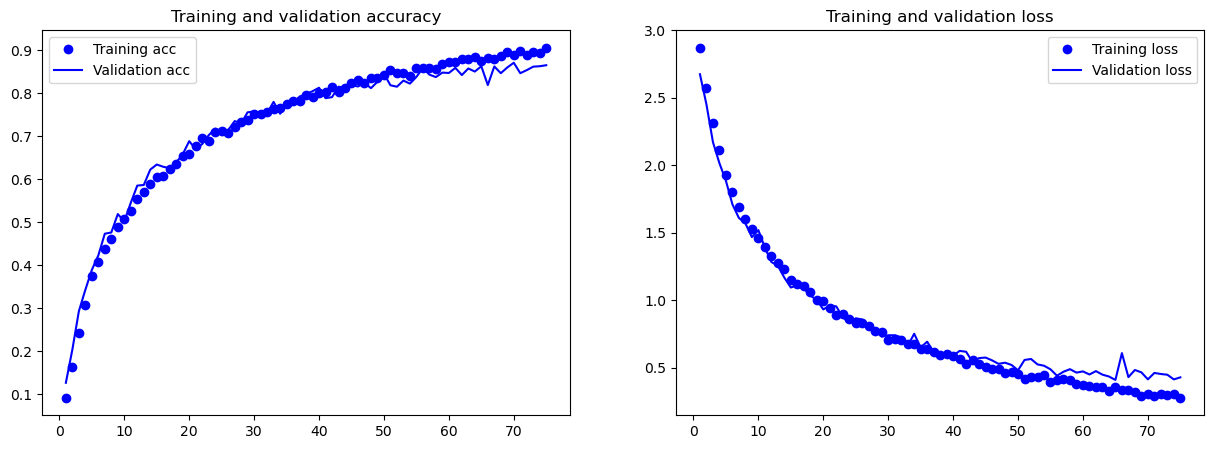

In [43]:
# Graficar las curvas de entrenamiento y validación
plot_history(history_cnn)

In [44]:
# Resultados
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(test_data, verbose=0)
num_params_cnn = model_cnn.count_params()
print("Pérdida final en el subconjunto test: {:.4f}".format(test_loss_cnn))
print("Exactitud final en el subconjunto test: {:.4f}".format(test_acc_cnn))
print(f"Número de parámetros: {num_params_cnn}")

Pérdida final en el subconjunto test: 0.4397
Exactitud final en el subconjunto test: 0.8505
Número de parámetros: 112437


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
¿Cúal es el número de parámetros a entrenar?
<br>
Hay 112.437 parámetros. (un 3.6% del modelo anterior)
<br><br>
¿y el tiempo de entrenamiento?
<br>
Aproximadamente 40 minutos utilizando una GPU
<br><br>
¿Qué precisión se obtiene con este modelo?
<br>
La pérdida final es de 0.4397 y la exactitud final de 0.8505
<br><br>
A diferencia del primer modelo, observamos un crecimiento en la curva de exactitud del modelo, tanto para el entrenamiento como la validación. Lo que nos indica que el modelo realmente esta aprendiendo a identificar los patrones de los datos para clasificar las imágenes. De misma manera, observamos en la gráfica que la pérdida decrece tanto en el subconjunto de entrenamiento como en el de validación.
</div>

## 4. Autoencoders (2 puntos)

En el apartado anterior hemos podido observar que, utilizando el tipo de redes adecuado, podemos obtener mejores resultados entrenando un número de parámetros muy inferior. Esto es debido a que las CNN consiguen extraer las características principales de los datos proporcionados (imágenes en nuestro caso).

En este apartado vamos a observar esta capacidad desde otro punto de vista: el de **codificar y decodificar una imagen**.

Para ello diseñaremos un autoencoder que sea capaz de reducir el tamaño de los datos de entrada pero captando las características principales de las imágenes para poder llevar a cabo una buena reconstrucción de las mismas.

Empezaremos rescalando externamente los datos que vamos a utilizar, para que estén en el rango (0,1), en lugar de realizarlo dentro de la red como hemos hecho en el apartado anterior:

In [9]:
# data rescalling
normalization_layer = Rescaling(1./255)

normalized_train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
normalized_val_data = val_data.map(lambda x, y: (normalization_layer(x), y))

Además, en un autoencoder, en lugar de utilizar las etiquetas como objetivo (que es lo que se utiliza en un problema de clasificación), deben ser las propias imágenes las que se utilicen como objetivo de la red. Por tanto, crearemos una nueva base de datos de entrenamiento y validación donde son las propias imágenes las que hagan de etiquetas:

In [10]:
train_data_auto = normalized_train_data.map(lambda x, y: (x, x))
val_data_auto = normalized_val_data.map(lambda x, y: (x, x))

Comprobamos la estructura de la nueva base de datos:

In [11]:
image_batch, label_batch = iter(train_data_auto).get_next()
print("Las dimensiones de un batch de imágenes es: {}".format(image_batch.shape))
print("Las dimensiones de un batch de etiquetas es: {}".format(label_batch.shape))

Las dimensiones de un batch de imágenes es: (32, 224, 224, 3)
Las dimensiones de un batch de etiquetas es: (32, 224, 224, 3)


Y que los datos tienen el rango dinámico adecuado:

In [12]:
first_image = image_batch[0]
print("En la primera imagen los valores mínimo y máximo son {} y {}, respectivamente"
      .format(np.min(first_image),np.max(first_image)))

En la primera imagen los valores mínimo y máximo son 0.15810328722000122 y 0.9944978952407837, respectivamente


### 4.1. Diseño y entrenamiento del autoencoder

Una vez ya tenemos los datos en el formato adecuado vamos a diseñar el autoencoder. Para ello utilizaremos el bloque extractor del apartado anterior como codificador y reflejaremos su estructura en el decodificador utilizando las capas [Conv2DTranspose](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/) y [UpSampling2D](https://keras.io/api/layers/reshaping_layers/up_sampling2d/) de keras.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio [1 punto]:</strong> A partir del modelo <strong>funcional</strong> de keras (y la clase <code>Model()</code>), implementa un autoencoder con las siguientes características:
    <ul>
        <li>El bloque codificador debe tener:
            <ul>
                <li>Una capa de entrada de dimensiones adecuadas a los datos.</li>
                <li>3 capas convolucionales con tamaño de kernel (5x5) para la primera y (3x3) para las 2 siguientes. Se utilizará padding '<i>same</i>' y activación ReLU. El número de filtros para cada capa convolucional será 16, 32 y 64 respectivamente.</li>
                <li>A cada capa convolucional le sigue una capa de <i>Max Pooling</i></li>
            </ul></li>
        <li>El bloque decodificador debe tener:
            <ul>
                <li>3 capas convolucionales con tamaño de kernel (3x3) para las 2 primeras y (5x5) para la última. Se utilizará padding '<i>same</i>' y activación ReLU. El número de filtros para cada capa convolucional será 64, 32 y 16, respectivamente</li>
                <li>A cada capa convolucional le sigue una capa de <i>UpSampling2D</i></li>
                <li>Una última capa convolucional con tamaño de kernel (3x3), con 3 filtros y activación sigmoide.</li>
            </ul></li>
    </ul>
    
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.001.</li>
         <li>Utilizar como función de pérdida el error cuadrático medio.</li>
         <li>Entrenar durante 100 épocas utilizando  <i>EarlyStopping</i> con una persistencia de 10 épocas, monitorizando la función de pérdida en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li>Monitorizar la pérdida durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas del <i>loss</i> (la curva de entrenamiento y la de validación).</li>
    </ul>
</div>



In [70]:
# Definición de la red

# Bloque codificador
# Capa de entrada
inputs = Input(shape=(224, 224, 3))

# 3 capas convolucionales con kernel 5x5,3x3,3x3. Se utilizará padding 'same' y activación ReLU.
# El número de filtros para cada capa convolucional será 16, 32 y 64 respectivamente.
# A cada capa convolucional le sigue una capa de Max Pooling
conv_layer1 = Conv2D(16, (5, 5), padding='same', activation='relu')(inputs)
pool_layer1 = MaxPooling2D((2, 2), padding='same')(conv_layer1)
conv_layer2 = Conv2D(32, (3, 3), padding='same', activation='relu')(pool_layer1)
pool_layer2 = MaxPooling2D((2, 2), padding='same')(conv_layer2)
conv_layer3 = Conv2D(64, (3, 3), padding='same', activation='relu')(pool_layer2)
encoded = MaxPooling2D((2, 2), padding='same')(conv_layer3)

# Bloque decodificador
# Inversa del bloque codificador
dec_conv_layer1 = Conv2D(64, (3, 3), padding='same', activation='relu')(encoded)
sample_layer1 = UpSampling2D((2, 2))(dec_conv_layer1)
dec_conv_layer2 = Conv2D(32, (3, 3), padding='same', activation='relu')(sample_layer1)
sample_layer2 = UpSampling2D((2, 2))(dec_conv_layer2)
dec_conv_layer3 = Conv2D(16, (5, 5), padding='same', activation='relu')(sample_layer2)
sample_layer3 = UpSampling2D((2, 2))(dec_conv_layer3)
decoded = Conv2DTranspose(3, (3, 3), padding='same', activation='sigmoid')(sample_layer3)

model_autoencoder = Model(inputs, decoded)

In [13]:
# Para cargar un modelo, descomentar la siguiente línea
#model_autoencoder = keras.models.load_model('../input/best-model-autoencoder/best_model_autoencoder.h5')

In [14]:
# Compilación de la red
model_autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [72]:
# Entrenamiento de la red

# EarlyStopping con una persistencia de 10 épocas (no hay mejora en 10 épocas)
# monitorizando la función de pérdida en el conjunto de validación (val_loss)
early_stop_autoencoder = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Guardando los pesos que mejor resultado hayan obtenido.
model_checkpoint_autoencoder = ModelCheckpoint(filepath='best_model_autoencoder.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Entrenar el modelo
history_autoencoder = model_autoencoder.fit(train_data_auto, epochs=100, 
                                            validation_data=val_data_auto, 
                                            callbacks=[early_stop_autoencoder,model_checkpoint_autoencoder], 
                                            verbose=1)

Epoch 1/100
229/230 [============================>.] - ETA: 0s - loss: 0.0059
Epoch 1: val_loss improved from inf to 0.00496, saving model to best_model_autoencoder.h5
230/230 [==============================] - 35s 151ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 2/100
229/230 [============================>.] - ETA: 0s - loss: 0.0048
Epoch 2: val_loss improved from 0.00496 to 0.00420, saving model to best_model_autoencoder.h5
230/230 [==============================] - 31s 133ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 3/100
229/230 [============================>.] - ETA: 0s - loss: 0.0043
Epoch 3: val_loss improved from 0.00420 to 0.00405, saving model to best_model_autoencoder.h5
230/230 [==============================] - 32s 134ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 4/100
229/230 [============================>.] - ETA: 0s - loss: 0.0040
Epoch 4: val_loss improved from 0.00405 to 0.00378, saving model to best_model_autoencoder.h5
230/230 [==============================]

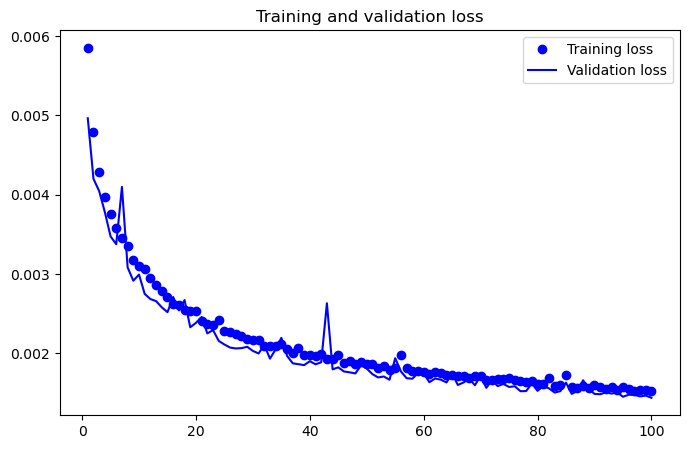

In [78]:
# Representación del loss
plot_history(history_autoencoder, accuracy=False)

### 4.2. Evaluación del autoencoder

La evaluación del modelo obtenido puede hacerse en este caso tanto de forma cuantitativa (calculando el MSE entre las imágenes originales y reconstruídas del conjunto de test) como cualitativa (mostrando imágenes originales y reconstruídas).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio [1 punto]:</strong> Realizar las siguientes operaciones para evaluar las prestaciones del modelo obtenido:
    <ul>
        <li>Partiendo del conjunto de test obtenido en el primer apartado de la practica:
            <ul>
                <li>Llevar a cabo el reescalado de los datos utilizando la capa <code>normalization_layer</code> tal y como se ha hecho con los conjuntos de entrenamiento y test al inicio de este bloque.</li>
                <li>Generar el conjunto de datos <code>test_data_auto</code> en el que las imágenes sean también el objetivo y substituyan a las etiquetas. </li>
            </ul></li>
        <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la exactitud final a partir de los datos de test.</li>
        <li>Imprimir por pantalla 4 parejas de imágenes (original y reconstruída). Nota: a la hora de representar las imágenes correctamente, recordad que su rango dinámico deben ser números enteros entre 0 y 255.</li>
    </ul>
    Preguntas: ¿Consideras que la reconstrucción es adecuada? ¿Qué <i>ratio</i> de compresión se consigue con este autoencoder? Consideramos como <i>ratio</i> de compresión la relación entre el tamaño original de la imagen (224,224,3) y el de la representación más perqueña que llega a hacer el codificador (tamaño de la salida de su última capa).

In [31]:
# Normalización de los datos
normalized_test_data = test_data.map(lambda x, y: (normalization_layer(x), y))
test_data_auto = normalized_test_data.map(lambda x, y: (x, x))

In [30]:
# Evaluación del modelo
results = model_autoencoder.evaluate(test_data_auto, verbose=0)
print(f"Pérdida del subconjunto test: {results}")

Pérdida del subconjunto test: 0.0014544522855430841


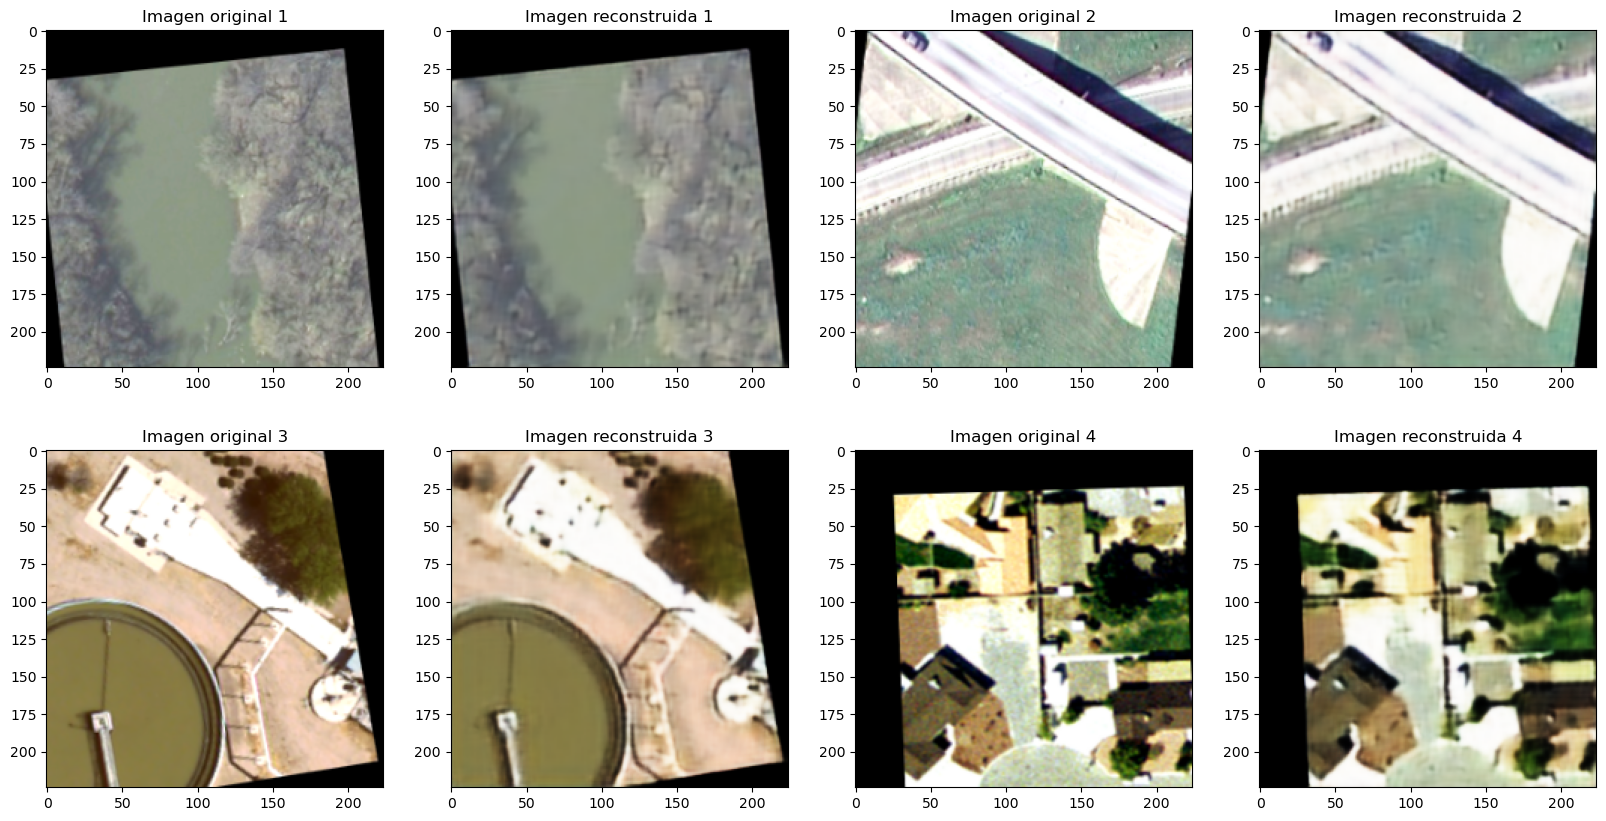

In [88]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior() # Necesito este import para visualizar correctamente la imagen

# Visualización de los datos
# Imprimir por pantalla 4 parejas de imágenes (original y reconstruída)
plt.figure(figsize=(20,10))
position,count = 1,1
image_batch, _ = next(iter(test_data_auto))
for i in range(4):
    # Imagen original
    plt.subplot(2,4,position)
    plt.imshow(image_batch[i])
    plt.title('Imagen original ' + str(count))
    position+=1 
    
    # Imagen reconstruida
    reconstructed = model_autoencoder.predict(image_batch[i].reshape(1,224,224,3),verbose=0)
    plt.subplot(2,4,position)
    plt.imshow(np.array(reconstructed.squeeze()*255).astype(np.uint8))
    plt.title('Imagen reconstruida ' + str(count))
    position+=1
    count += 1
plt.show()

In [85]:
# Tamaño de la entrada del codificador (None, 224, 224, 3)
encoder_input = inputs.shape
num_input = encoder_input[1]*encoder_input[2]*encoder_input[3]
print("Tamaño de la entrada del codificador:", encoder_input, "=",num_input, "neuronas")

# Tamaño de la última capa del codificador
encoder_output = encoded.shape
num_codings = encoder_output[1] * encoder_output[2] * encoder_output[3]
print("Tamaño de la salida del codificador:", encoder_output, "=",num_codings, "neuronas")

# Ratio de compresión
compression_ratio = num_input / num_codings
print("Ratio de compresión:", compression_ratio)


Tamaño de la entrada del codificador: (None, 224, 224, 3) = 150528 neuronas
Tamaño de la salida del codificador: (None, 28, 28, 64) = 50176 neuronas
Ratio de compresión: 3.0


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
¿Consideras que la reconstrucción es adecuada?
<br>
Podemos observar que el autoencoder es capaz de reconstruir la imagen a un buen nivel. Se detecta cierta difusión, que es lo esperado.
<br><br>
¿Qué ratio de compresión se consigue con este autoencoder?
<br>
Un ratio de compresión de 3. Indicando que la capa más pequeña es 3 veces más pequeña que la entrada del autoencoder.
<br><br>
</div>

## 5. Red VGG16 y transfer learning (2 puntos)

Las redes neuronales convolucionales profundas nos brindan la posibilidad de mejorar la capacidad de aprendizaje de un modelo. Algunas arquitecturas comunes, pueden incluir cientos de capas convolucionales. No obstante, entrenar estas arquitecturas desde cero puede resultar costoso tanto en términos de tiempo como de recursos, además de requerir conjuntos de datos bastante grandes.

### 5.1. Transfer Learning
En este apartado, aplicaremos [transfer learning](https://keras.io/guides/transfer_learning/) con el fin de ahorrarnos parte de dicho entrenamiento. Esta metodología consiste en aprovechar los pesos de un modelo entrenado en otra base de datos y para otra tarea. En concreto, utilizaremos el modelo [VGG16](https://keras.io/api/applications/vgg/#vgg16-function) preentrenado en [Imagenet](http://www.image-net.org/), y lo adaptaremos para clasificar las 21 categorías de nuestra base de datos. En la versión de VGG16 de keras existe la opción de cargar los pesos entrenados en Imagenet sin las 3 capas totalmente conectadas de la parte final de la red (opción <code>include_top = False</code>), nosotros substituiremos esas 3 capas y reentrenaremos el conjunto con el resto de pesos congelados.

Para reutilizar el modelo correctamente es necesario preprocesar los datos tal y como se hizo durante el entrenamiento en la base de datos original. Keras nos facilita aplicar la normalización en el caso de modelos preentrenados; para el caso de VGG16 revisar la documentación de [prepocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input) (tened en cuenta que la función se aplica sobre imágenes con rango dinámico de 0 a 255).


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio[1 punto]:</strong> Implementa una red siguiendo los siguientes pasos:
    <ul>
        <li>Partir del modelo VGG16 con los pesos entrenados en Imagenet y congelarlos</li>
        <li>Substituir las 3 últimas capas completamente conectadas por 3 capas nuevas: las 2 primeras de 50 y 20 neuronas respectivamente con activación ReLU, y una última capa con el número de neuronas adecuado para llevar a cabo la tarea de clasificación sobre nuestra base de datos y la función de activación adecuada.</li> 
    </ul>
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.0001.</li>
         <li>Entrenar durante 100 épocas utilizando  <i>EarlyStopping</i> con una persistencia de 10 épocas, monitorizando la <i>accuracy</i> en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li>Monitorear la métrica  <i>accuracy</i> durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas de accuracy y loss. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación.</li>
         <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la exactitud final a partir de los datos de test.</li>
    </ul>
    Preguntas a responder: ¿Cúal es el número de parámetros a entrenar? ¿y el tiempo de entrenamiento? ¿Qué precisión se obtiene con este modelo? Comenta los resultados.
</div>

In [12]:
# Para cargar un modelo, descomentar la siguiente línea
#model_vgg16 = keras.models.load_model('../input/best-model-vgg16/best_model_vgg16.h5')

In [14]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Cargar modelo VGG16 entrenado con imagenet. No incluimos las últimas 3 capas Dense, ni la última capa Flatten
# usando include_top=False
model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
# No queremos entrenar las capas que ya han sido entrenadas
for layer in model_vgg16.layers:
    layer.trainable = False

In [14]:
# Comprobamos que estan como False
model_vgg16.layers[-1].trainable

False

In [23]:
# Definición de la red
# Como hemos quitado la capa Flatten del modelo vgg16 la añadimos
flatten_layer = Flatten()(model_vgg16.output)

# Tambien añadimos 3 capas fc, según las especificaciones del enunciado
dense_layer1 = Dense(50, activation='relu')(flatten_layer)
dense_layer2 = Dense(20, activation='relu')(dense_layer1)
output = Dense(len(classes), activation='softmax')(dense_layer2)

model_vgg16 = Model(inputs=model_vgg16.input, outputs=output)

In [15]:
# Compilación de la red
model_vgg16.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [38]:
# Preprocesamiento de input data
# He obtado por no utilizar la función preprocess_input, ya que me ha proporcionado significativamente peores resultados

#preprocessed_train_data = train_data.map(lambda x, y: (preprocess_input(x), y))
#preprocessed_val_data = val_data.map(lambda x, y: (preprocess_input(x), y))
#preprocessed_test_data = test_data.map(lambda x, y: (preprocess_input(x), y))

In [137]:
# Entrenamiento de la red
early_stop_vgg16 = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
model_checkpoint_vgg16 = ModelCheckpoint('best_model_vgg16.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

history_vgg16 = model_vgg16.fit(train_data, epochs=100, validation_data=val_data, callbacks=[early_stop_vgg16, model_checkpoint_vgg16])

Epoch 1/100
230/230 [==============================] - ETA: 0s - loss: 2.6892 - accuracy: 0.2561
Epoch 1: val_accuracy improved from -inf to 0.44714, saving model to best_model_vgg16.h5
230/230 [==============================] - 71s 275ms/step - loss: 2.6892 - accuracy: 0.2561 - val_loss: 1.8848 - val_accuracy: 0.4471
Epoch 2/100
230/230 [==============================] - ETA: 0s - loss: 1.2272 - accuracy: 0.6327
Epoch 2: val_accuracy improved from 0.44714 to 0.66190, saving model to best_model_vgg16.h5
230/230 [==============================] - 43s 184ms/step - loss: 1.2272 - accuracy: 0.6327 - val_loss: 1.2652 - val_accuracy: 0.6619
Epoch 3/100
230/230 [==============================] - ETA: 0s - loss: 0.6280 - accuracy: 0.7993
Epoch 3: val_accuracy improved from 0.66190 to 0.72048, saving model to best_model_vgg16.h5
230/230 [==============================] - 43s 187ms/step - loss: 0.6280 - accuracy: 0.7993 - val_loss: 1.0952 - val_accuracy: 0.7205
Epoch 4/100
230/230 [=============

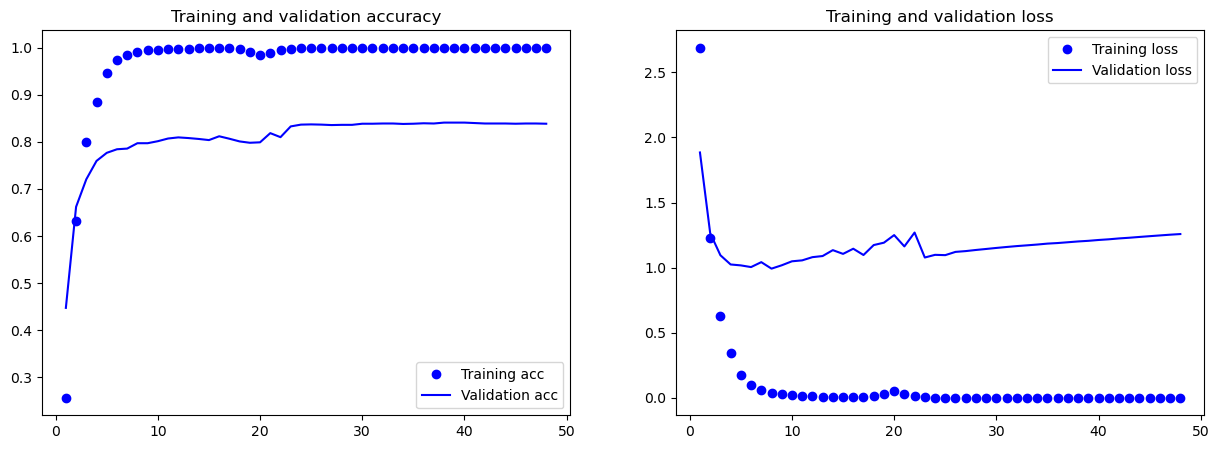

In [139]:
plot_history(history_vgg16)

In [141]:
# Resultados
test_loss_vgg16, test_acc_vgg16 = model_vgg16.evaluate(test_data, verbose=0)
num_params_vgg16 = model_vgg16.count_params()
print("Pérdida final en el subconjunto test: {:.4f}".format(test_loss_vgg16))
print("Exactitud final en el subconjunto test: {:.4f}".format(test_acc_vgg16))
print(f"Número de parámetros: {num_params_vgg16}")

Pérdida final en el subconjunto test: 1.1055
Exactitud final en el subconjunto test: 0.8352
Número de parámetros: 15970599


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
¿Cúal es el número de parámetros a entrenar?
<br>
Hay 15.970.599 parámetros
<br><br>
¿y el tiempo de entrenamiento?
<br>
Aproximadamente 36 minutos utilizando una GPU
<br><br>
¿Qué precisión se obtiene con este modelo?
<br>
La exactitud final es de 0.8352
<br><br>
Al utilizar la función preprocess_input sobre el dataset he obtenido una peor precisión del modelo, por lo que he obtado no utilizarla. En las gráficas, se ve una clara mejora en exactitud y pérdida. Aun así, el subconjunto de validación no obtiene el mismo rendimiento que el subconjunto de entrenamiento, por lo que el modelo podría estar sufriendo overfitting en cierta medida.
</div>

### 5.2. Fine-tunning
Una técnica frecuente, sobretodo cuando la red utilizada no es excesivamente grande (como es el caso de VGG16), para mejorar los resultados del <i>transfer learning</i> es el denominado <i>fine-tunning</i>,  que consiste en reentrenar la red completa durante unas pocas épocas y con un <i>learning rate</i> muy pequeño.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio[1 punto]:</strong> Volver a compilar el modelo con los siguientes cambios:
    <ul>
        <li>Descongelar los pesos del modelo VGG16 poniendo <code>trainable=True</code> (no confundir con <code>traning=False</code>).</li>
    </ul>
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.00001.</li>
         <li>Entrenar durante 10 épocas utilizando  <i>EarlyStopping</i> con una persistencia de 10 épocas monitorizando la <i>accuracy</i> en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li>Monitorizar la métrica  <i>accuracy</i> durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas de accuracy y loss. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación.</li>
         <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la exactitud final a partir de los datos de test.</li>
    </ul>
    Preguntas a responder: ¿Cúal es el número de parámetros a entrenar? ¿y el tiempo de entrenamiento? ¿Qué precisión se obtiene con este modelo? Comenta los resultados teniendo en cuenta el proceso global: <i>transfer lerning</i> + <i> fine-tunning</i>.
</div>


In [17]:
# Definición del modelo
for layer in model_vgg16.layers:
    layer.trainable = True

In [148]:
# Compilación de la red
model_vgg16.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [149]:
# Entrenamiento
early_stop_vgg16_ft = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
model_checkpoint_vgg16_ft = ModelCheckpoint('best_model_vgg16_ft.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

history_vgg16_ft = model_vgg16.fit(train_data, epochs=100, validation_data=val_data, callbacks=[early_stop_vgg16_ft, model_checkpoint_vgg16_ft])

Epoch 1/100
230/230 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9990
Epoch 1: val_accuracy improved from -inf to 0.83667, saving model to best_model_vgg16_ft.h5
230/230 [==============================] - 45s 190ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 1.3899 - val_accuracy: 0.8367
Epoch 2/100
230/230 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9954
Epoch 2: val_accuracy did not improve from 0.83667
230/230 [==============================] - 43s 185ms/step - loss: 0.0183 - accuracy: 0.9954 - val_loss: 1.4415 - val_accuracy: 0.8243
Epoch 3/100
230/230 [==============================] - ETA: 0s - loss: 0.0295 - accuracy: 0.9936
Epoch 3: val_accuracy did not improve from 0.83667
230/230 [==============================] - 43s 185ms/step - loss: 0.0295 - accuracy: 0.9936 - val_loss: 1.5146 - val_accuracy: 0.8271
Epoch 4/100
230/230 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9980
Epoch 4: val_acc

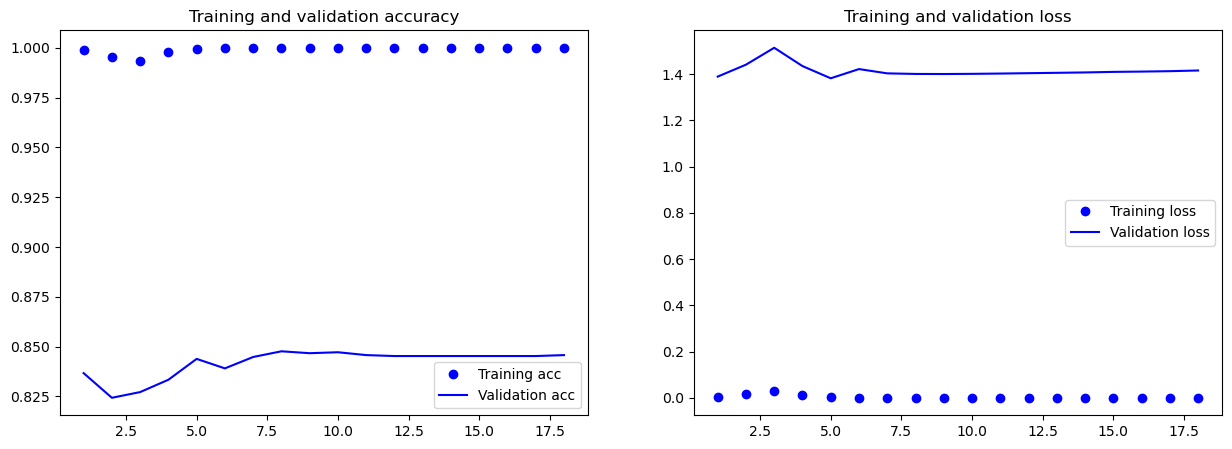

In [150]:
plot_history(history_vgg16_ft)

In [151]:
# Resultados
test_loss_vgg16_ft, test_acc_vgg16_ft = model_vgg16.evaluate(test_data, verbose=0)
num_params_vgg16_ft = model_vgg16.count_params()
print("Pérdida final en el subconjunto test: {:.4f}".format(test_loss_vgg16_ft))
print("Exactitud final en el subconjunto test: {:.4f}".format(test_acc_vgg16_ft))
print(f"Número de parámetros: {num_params_vgg16_ft}")

Pérdida final en el subconjunto test: 1.1475
Exactitud final en el subconjunto test: 0.8610
Número de parámetros: 15970599


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
¿Cúal es el número de parámetros a entrenar?
<br>
Hay 15.970.599 parámetros
<br><br>
¿y el tiempo de entrenamiento?
<br>
Aproximadamente 50 minutos utilizando una GPU. (36 minutos para transfer learning y 14 para fine-tuning).
<br><br>
¿Qué precisión se obtiene con este modelo?
<br>
La exactitud final es de 0.8610
<br><br>
Al hacer un fine-tunning del modelo hemos conseguido una mejora de alrededor de un 4%. En la gráfica de "Training and validation accuracy" Se puede observar un pequeño salto en la exactitud del modelo sobre el subconjunto de validación. Esto nos indica que el modelo ha aprendido a reconocer los patrones de una manera más abstracta (menos overfitting). La segunda gráfica no es muy larga ya que solo he ploteado el fine-tunning de 8 épocas.
<br><br>
</div>

## 6. Mejora de resultados (1 punto)

En este último apartado se deja libertad al alumno para conseguir, mediante el diseño de una red propia, unos mejores resultados en la tarea de clasificación.

Se valorarará la justificación de las elecciones realizadas.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio[1 punto]:</strong> Implementar un modelo para llevar a cabo la tarea de clasificación:
    <ul>
        <li>Diseñar la arquitectura de la red</li>
        <li>Compilar el modelo</li>
        <li>Llevar a cabo el entrenamientio</li>
        <li>Evaluar el modelo presentando las métricas y gráficas adecuadas</li>
        <li>Comentar los resultados obtenidos</li>
    </ul>
</div>

In [11]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [12]:
# Descomentar para cargar modelo
#model_resnet50 = keras.models.load_model('../input/best-model-resnet50/best_model_resnet50.h5')

In [15]:
model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 1s 0us/step


In [16]:
#  Queremos entrenar las capas que ya han sido entrenadas
for layer in model_resnet50.layers:
    layer.trainable = True

Primer intento:

Está arquitectura consiguió en el subconjunto de test:
    
    - una exactitud de 0.9314
    - una pérdida final de 0.3064
    
Número de parámetros: 25.695.125

In [22]:
# Definición de la red
#flatten_layer = Flatten()(model_resnet50.output)
#output = Dense(len(classes), activation='softmax')(flatten_layer)
#model_resnet50 = Model(inputs=model_resnet50.input, outputs=output)

Segundo intento:

Está arquitectura consiguió en el subconjunto de test:
    
    - una exactitud de 0.9867
    - una pérdida final de 0.0478
    
Número de parámetros: 25.707.413

In [17]:
# Definición de la red
avg_pool_layer = GlobalAveragePooling2D()(model_resnet50.output)
dense_layer = Dense(1024, activation='relu')(avg_pool_layer)
output = Dense(len(classes), activation='softmax')(dense_layer)

model_resnet50 = Model(inputs=model_resnet50.input, outputs=output)

In [18]:
# Compilación de la red
model_resnet50.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Entrenamiento de la red
early_stop_resnet50 = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
model_checkpoint_resnet50 = ModelCheckpoint('best_model_resnet50.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

history_resnet50 = model_resnet50.fit(train_data, epochs=100, validation_data=val_data, callbacks=[early_stop_resnet50, model_checkpoint_resnet50])

Epoch 1/100
230/230 [==============================] - ETA: 0s - loss: 0.3805 - accuracy: 0.8863
Epoch 1: val_accuracy improved from -inf to 0.92905, saving model to best_model_resnet50.h5
230/230 [==============================] - 118s 431ms/step - loss: 0.3805 - accuracy: 0.8863 - val_loss: 0.2389 - val_accuracy: 0.9290
Epoch 2/100
230/230 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.9797
Epoch 2: val_accuracy improved from 0.92905 to 0.95571, saving model to best_model_resnet50.h5
230/230 [==============================] - 89s 383ms/step - loss: 0.0694 - accuracy: 0.9797 - val_loss: 0.1528 - val_accuracy: 0.9557
Epoch 3/100
230/230 [==============================] - ETA: 0s - loss: 0.0438 - accuracy: 0.9871
Epoch 3: val_accuracy improved from 0.95571 to 0.96714, saving model to best_model_resnet50.h5
230/230 [==============================] - 87s 373ms/step - loss: 0.0438 - accuracy: 0.9871 - val_loss: 0.1116 - val_accuracy: 0.9671
Epoch 4/100
230/230 [===

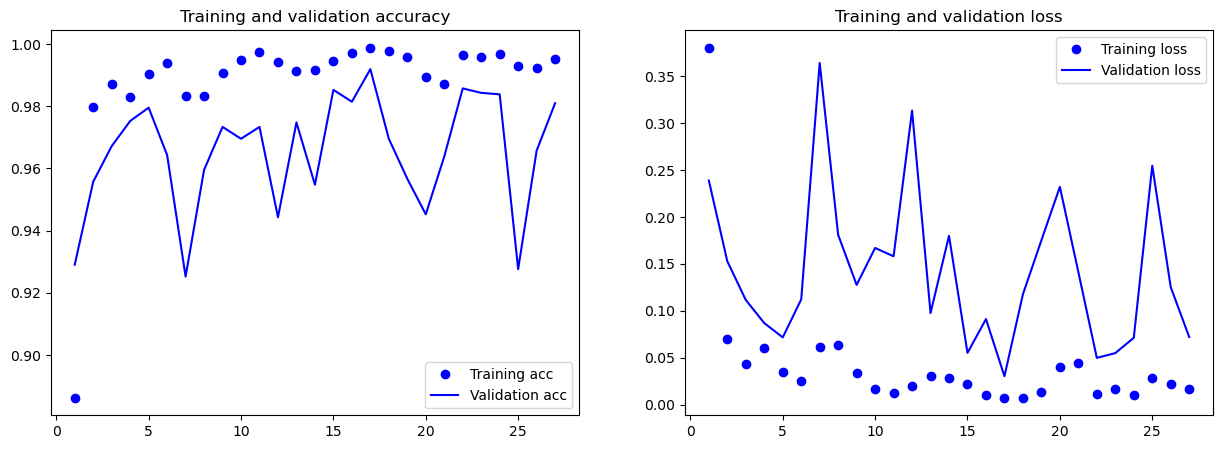

In [20]:
plot_history(history_resnet50)

In [21]:
# Resultados
test_loss_resnet50, test_acc_resnet50 = model_resnet50.evaluate(test_data, verbose=0)
num_params_resnet50 = model_resnet50.count_params()
print("Pérdida final en el subconjunto test: {:.4f}".format(test_loss_resnet50))
print("Exactitud final en el subconjunto test: {:.4f}".format(test_acc_resnet50))
print(f"Número de parámetros: {num_params_resnet50}")

Pérdida final en el subconjunto test: 0.0478
Exactitud final en el subconjunto test: 0.9867
Número de parámetros: 25707413


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
Rendimiento de modelos creados por exactitud:
    <br><br>
Modelo ANN - 0.2390
<br>
Modelo CNN - 0.8505
<br>
Modelo VGG16 (Transfer Training) - 0.8352
<br>
Modelo VGG16 (Fine-Tunning) - 0.8610
<br>
1r Intento Modelo Propio (ResNet50) - 0.9314
<br>
2o Intento Modelo Propio (ResNet50) - 0.9867
<br><br>
Para el modelo he optado por la arquitectura ResNet50. He encontrado este modelo al buscar el dataset online y mejor rendimiento de modelos. Los mejores modelos fueron: µ2Net+, ResNet50 y MSMatch. Dado que ResNet50 está incluido en keras.application he optado por este.
<br><br>
Una vez seleccionado el modelo he probado añadiendo una capa Flatten y una capa Dense con el número de clases consiguiendo una exactitud de 0.9314
<br><br>
Dado que ResNet50 supuestamente consigué una exactitud de 98-99.6% he probado otra combinación.

El segundo intento es una capa GlobalAveragePooling2D, una capa Dense con 1024 neuronas (enfoque estándar) y una capa Dense con las 21 clases. Este segundo intento ha conseguido una exactitud de 98.67%
    
https://paperswithcode.com/sota/scene-classification-on-uc-merced-land-use
    
También encontramos más modelos aquí: https://keras.io/api/applications/
<br><br>
</div>